1. Rainbow and Ape-X Expiriments 
    1. We release a set of hyper parameters for CartPole-v1 and Classic Control and Atari
    5. We graph the convergence of Hyperopt for both tensorflow and torch, we do a score/trials graph and we compare to random hyper parameters 
    6. We graph the exploration of the Hyperopt algorithm showing the difference between consecutive trials to measure when the algorithm is “confident” in its parameters
    7. Compare search space sizes
        1. Large all hp.choice
        2. small/medium hp.choice
        3. a set using hp.uniform etc 
    8. Different methods
        1. tuning only 1 part of the system at a time and then tuning the next part, from a base set of params 
            1. DQN, then PER, then Double… 
    9. Different testing methods, like for example rolling average instead of latest test score

## Baseline Parameter Training Results
10,000 frames

Config provided below

In [ ]:
import gymnasium as gym
from gymnasium.wrappers import AtariPreprocessing, FrameStack
import numpy as np
import sys
sys.path.append('../..')
from dqn.rainbow.rainbow_agent import RainbowAgent
from game_configs import AtariConfig, CartPoleConfig
from agent_configs import RainbowConfig
from utils import KLDivergence
import random
import torch

# env = ClipReward(AtariPreprocessing(gym.make("MsPacmanNoFrameskip-v4", render_mode="rgb_array"), terminal_on_life_loss=True), -1, 1) # as recommended by the original paper, should already include max pooling
# env = FrameStack(env, 4)
env = gym.make("CartPole-v1")


config_dict = {
  "dense_layers_widths": [128],
  "value_hidden_layers_widths": [128],
  "advatage_hidden_layers_widths": [128],
  "adam_epsilon": 1e-8,
  "learning_rate": 0.001,
  "training_steps": 10000,
  "per_epsilon": 1e-6,
  "per_alpha": 0.2,
  "per_beta": 0.6,
  "minibatch_size": 128,
  "transfer_interval": 100,
  "n_step": 3,
  "noisy_sigma": 0.5,
  "replay_interval": 1,
  "kernel_initializer": "orthogonal",
  "noisy_sigma": 0.5,
  "loss_function": KLDivergence(), # could do categorical cross entropy 
  "clipnorm": 10.0,
}
game_config = CartPoleConfig()
config = RainbowConfig(config_dict, game_config)
agent = RainbowAgent(env, config, name="baseline")

for param in agent.model.parameters():
  print(param)
print("start")
agent.train()

# Hyperparameter optimization of Rainbow on Cartpole-v1

## Hyperopt with PyTorch and TensorFlow only hp.choice()
Training steps: 10,000 (5,000 for TesnorFlow)

Evaluation: Average score of 10 episodes from random starts with final network weights.

In [ ]:
import pickle
from hyperopt import hp
from utils import CategoricalCrossentropy, KLDivergence, generate_layer_widths
import gymnasium as gym 

width_combinations = generate_layer_widths([32, 64, 128, 256, 512, 1024], 5)

search_space = {
        "kernel_initializer": hp.choice(
            "kernel_initializer",
            [
                "he_uniform",
                "he_normal",
                "glorot_uniform",
                "glorot_normal",
                "orthogonal",
            ],
        ),
        "learning_rate": hp.choice(
            "learning_rate", [10, 5, 2, 1, 0.1, 0.01, 0.001, 0.0001, 0.00001]
        ),
        "adam_epsilon": hp.choice(
            "adam_epsilon", [0.3125, 0.03125, 0.003125, 0.0003125]
        ),
        "loss_function": hp.choice(
            "loss_function", [CategoricalCrossentropy(), KLDivergence()]
        ),
        # NORMALIZATION?
        "transfer_interval": hp.choice(
            "transfer_interval", [10, 25, 50, 100, 200, 400, 800, 1600, 2000]
        ),
        "replay_interval": hp.choice("replay_interval", [1, 2, 3, 4, 5, 8, 10, 12]),
        "minibatch_size": hp.choice(
            "minibatch_size", [2**i for i in range(4, 8)]
        ),  ###########
        "replay_buffer_size": hp.choice(
            "replay_buffer_size",
            [2000, 3000, 5000, 7500, 10000],
        ),  #############
        "min_replay_buffer_size": hp.choice(
            "min_replay_buffer_size",
            [125, 250, 375, 500, 625, 750, 875, 1000, 1500, 2000],
        ),  # 125, 250, 375, 500, 625, 750, 875, 1000, 1500, 2000
        "n_step": hp.choice("n_step", [3, 4, 5, 8, 10]),
        "discount_factor": hp.choice("discount_factor", [0.9, 0.99, 0.995, 0.999]),
        "atom_size": hp.choice("atom_size", [51, 61, 71, 81]),  #
        "conv_layers": hp.choice("conv_layers", [[]]),
        "dense_layers_widths": hp.choice("dense_layers_widths", width_combinations),
        "advantage_hidden_layers_widths": hp.choice(
            "advantage_hidden_layers_widths", width_combinations
        ),  #
        "value_hidden_layers_widths": hp.choice(
            "value_hidden_layers_widths", width_combinations
        ),  #
        "training_steps": hp.choice("training_steps", [10000]),
        "per_epsilon": hp.choice("per_epsilon", [0.00001, 0.0001, 0.001, 0.01, 0.1]),
        "per_alpha": hp.choice("per_alpha", [0.05 * i for i in range(1, 21)]),
        "per_beta": hp.choice("per_beta", [0.05 * i for i in range(1, 21)]),
        "clipnorm": hp.choice("clipnorm", [None, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0]),
    }

initial_best_config = [{}]


pickle.dump(search_space, open("./search_spaces/torch_choice_search_search_space.pkl", "wb"))
pickle.dump(initial_best_config, open("./search_spaces/torch_choice_search_initial_best_config.pkl", "wb"))

%run ./hyperparameter_optimization.py ./search_spaces/torch_choice_search_search_space.pkl ./search_spaces/torch_choice_search_initial_best_config.pkl ClassicControl-v1_search_choice final_score

## Hyperopt with Torch and hp.uniform, hp.loguniform, etc...
Training steps: 10,000 (5,000 for TesnorFlow)

Evaluation: Average score of 10 episodes from random starts with final network weights.

In [ ]:
import pickle
from hyperopt import hp
from hyperopt.pyll import scope
from utils import CategoricalCrossentropy, KLDivergence, generate_layer_widths
import gymnasium as gym 
import numpy as np

width_combinations = generate_layer_widths([32, 64, 128, 256, 512, 1024], 5)
# print(width_combinations)

search_space = {
        "kernel_initializer": hp.choice(
            "kernel_initializer",
            [
                "he_uniform",
                "he_normal",
                "glorot_uniform",
                "glorot_normal",
                "orthogonal",
            ],
        ),
        "learning_rate": hp.qloguniform('learning_rate', np.log(0.00001), np.log(1.0), 0.00001),
        "adam_epsilon": hp.qloguniform('adam_epsilon', np.log(0.0003125), np.log(0.3125), 0.0003125),
        "loss_function": hp.choice(
            "loss_function", [CategoricalCrossentropy(), KLDivergence()]
        ),
        # NORMALIZATION?
        "transfer_interval": scope.int(hp.qloguniform('transfer_interval', np.log(10), np.log(2000), 10)),
        "replay_interval": hp.uniformint('replay_interval', 1, 12),
        "minibatch_size": scope.int(hp.quniform('minibatch_size', 16, 128, 16)),  ###########
        "replay_buffer_size": scope.int(hp.quniform('replay_buffer_size', 2000, 10000, 1000)),  #############
        "min_replay_buffer_size": scope.int(hp.quniform('min_replay_buffer_size', 125, 2000, 125)), 
        "n_step": hp.uniformint('n_step', 2, 10),
        "discount_factor": hp.qloguniform('discount_factor', np.log(0.9), np.log(0.999), 0.001),
        "atom_size": scope.int(hp.quniform('atom_size', 51, 81, 10) + 1),  #
        "conv_layers": hp.choice("conv_layers", [[]]),
        "dense_layers_widths": hp.choice("dense_layers_widths", width_combinations),
        "advantage_hidden_layers_widths": hp.choice(
            "advantage_hidden_layers_widths", width_combinations
        ),  #
        "value_hidden_layers_widths": hp.choice(
            "value_hidden_layers_widths", width_combinations
        ),  #
        "training_steps": hp.choice("training_steps", [10000]),
        "per_epsilon": hp.qloguniform('per_epsilon', np.log(0.00001), np.log(0.1), 0.00001),
        "per_alpha": hp.quniform('per_alpha', 0.05, 1.0, 0.05),
        "per_beta": hp.quniform('per_beta', 0.05, 1.0, 0.05),
        "clipnorm": hp.qloguniform('clipnorm', np.log(0.1), np.log(100.0), 0.1)
    }

initial_best_config = [{}]


pickle.dump(search_space, open("./search_spaces/torch_quantized_search_search_space.pkl", "wb"))
pickle.dump(initial_best_config, open("./search_spaces/torch_quantized_search_initial_best_config.pkl", "wb"))

%run ../../dqn/rainbow/hyperparameter_optimization.py ./search_spaces/torch_quantized_search_search_space.pkl ./search_spaces/torch_quantized_search_initial_best_config.pkl CartPole-v1_quantized_search final_score

## Hyperopt for Torch on Cartpole-v1 using averaging evaluation and average + final_score
Training steps: 10,000 (5,000 for TesnorFlow)

Evaluation: Rolling average score of last 10 testing scores (which consist of 10 games), for + final_score the final_score is weighted 50%

In [ ]:
import pickle
from hyperopt import hp
from hyperopt.pyll import scope
from utils import CategoricalCrossentropy, KLDivergence, generate_layer_widths
import gymnasium as gym 
import numpy as np

width_combinations = generate_layer_widths([32, 64, 128, 256, 512, 1024], 5)
# print(width_combinations)

search_space = {
        "kernel_initializer": hp.choice(
            "kernel_initializer",
            [
                "he_uniform",
                "he_normal",
                "glorot_uniform",
                "glorot_normal",
                "orthogonal",
            ],
        ),
        "learning_rate": hp.qloguniform('learning_rate', np.log(0.00001), np.log(1.0), 0.00001),
        "adam_epsilon": hp.qloguniform('adam_epsilon', np.log(0.0003125), np.log(0.3125), 0.0003125),
        "loss_function": hp.choice(
            "loss_function", [CategoricalCrossentropy(), KLDivergence()]
        ),
        # NORMALIZATION?
        "transfer_interval": scope.int(hp.qloguniform('transfer_interval', np.log(10), np.log(2000), 10)),
        "replay_interval": hp.uniformint('replay_interval', 1, 12),
        "minibatch_size": scope.int(hp.quniform('minibatch_size', 16, 128, 16)),  ###########
        "replay_buffer_size": scope.int(hp.quniform('replay_buffer_size', 2000, 10000, 1000)),  #############
        "min_replay_buffer_size": scope.int(hp.quniform('min_replay_buffer_size', 125, 2000, 125)), 
        "n_step": hp.uniformint('n_step', 2, 10),
        "discount_factor": hp.qloguniform('discount_factor', np.log(0.9), np.log(0.999), 0.001),
        "atom_size": scope.int(hp.quniform('atom_size', 51, 81, 10) + 1),  #
        "conv_layers": hp.choice("conv_layers", [[]]),
        "dense_layers_widths": hp.choice("dense_layers_widths", width_combinations),
        "advantage_hidden_layers_widths": hp.choice(
            "advantage_hidden_layers_widths", width_combinations
        ),  #
        "value_hidden_layers_widths": hp.choice(
            "value_hidden_layers_widths", width_combinations
        ),  #
        "training_steps": hp.choice("training_steps", [10000]),
        "per_epsilon": hp.qloguniform('per_epsilon', np.log(0.00001), np.log(0.1), 0.00001),
        "per_alpha": hp.quniform('per_alpha', 0.05, 1.0, 0.05),
        "per_beta": hp.quniform('per_beta', 0.05, 1.0, 0.05),
        "clipnorm": hp.qloguniform('clipnorm', np.log(0.1), np.log(100.0), 0.1)
    }

initial_best_config = [{}]


pickle.dump(search_space, open("./search_spaces/rolling_average_eval_search_space.pkl", "wb"))
pickle.dump(initial_best_config, open("./search_spaces/rolling_average_eval_initial_best_config.pkl", "wb"))

%run ../../dqn/rainbow/hyperparameter_optimization.py ./search_spaces/rolling_average_eval_search_space.pkl ./search_spaces/rolling_average_eval_initial_best_config.pkl CartPole-v1_rolling_average_eval rolling_average

In [ ]:
import pickle
from hyperopt import hp
from hyperopt.pyll import scope
from utils import CategoricalCrossentropy, KLDivergence, generate_layer_widths
import gymnasium as gym 
import numpy as np

width_combinations = generate_layer_widths([32, 64, 128, 256, 512, 1024], 5)
# print(width_combinations)

search_space = {
        "kernel_initializer": hp.choice(
            "kernel_initializer",
            [
                "he_uniform",
                "he_normal",
                "glorot_uniform",
                "glorot_normal",
                "orthogonal",
            ],
        ),
        "learning_rate": hp.qloguniform('learning_rate', np.log(0.00001), np.log(1.0), 0.00001),
        "adam_epsilon": hp.qloguniform('adam_epsilon', np.log(0.0003125), np.log(0.3125), 0.0003125),
        "loss_function": hp.choice(
            "loss_function", [CategoricalCrossentropy(), KLDivergence()]
        ),
        # NORMALIZATION?
        "transfer_interval": scope.int(hp.qloguniform('transfer_interval', np.log(10), np.log(2000), 10)),
        "replay_interval": hp.uniformint('replay_interval', 1, 12),
        "minibatch_size": scope.int(hp.quniform('minibatch_size', 16, 128, 16)),  ###########
        "replay_buffer_size": scope.int(hp.quniform('replay_buffer_size', 2000, 10000, 1000)),  #############
        "min_replay_buffer_size": scope.int(hp.quniform('min_replay_buffer_size', 125, 2000, 125)), 
        "n_step": hp.uniformint('n_step', 2, 10),
        "discount_factor": hp.qloguniform('discount_factor', np.log(0.9), np.log(0.999), 0.001),
        "atom_size": scope.int(hp.quniform('atom_size', 51, 81, 10) + 1),  #
        "conv_layers": hp.choice("conv_layers", [[]]),
        "dense_layers_widths": hp.choice("dense_layers_widths", width_combinations),
        "advantage_hidden_layers_widths": hp.choice(
            "advantage_hidden_layers_widths", width_combinations
        ),  #
        "value_hidden_layers_widths": hp.choice(
            "value_hidden_layers_widths", width_combinations
        ),  #
        "training_steps": hp.choice("training_steps", [10000]),
        "per_epsilon": hp.qloguniform('per_epsilon', np.log(0.00001), np.log(0.1), 0.00001),
        "per_alpha": hp.quniform('per_alpha', 0.05, 1.0, 0.05),
        "per_beta": hp.quniform('per_beta', 0.05, 1.0, 0.05),
        "clipnorm": hp.qloguniform('clipnorm', np.log(0.1), np.log(100.0), 0.1)
    }

initial_best_config = [{}]


pickle.dump(search_space, open("./search_spaces/final_score_rolling_average_eval_search_space.pkl", "wb"))
pickle.dump(initial_best_config, open("./search_spaces/final_score_rolling_average_eval_initial_best_config.pkl", "wb"))

%run ../../dqn/rainbow/hyperparameter_optimization.py ./search_spaces/final_score_rolling_average_eval_search_space.pkl ./search_spaces/final_score_rolling_average_eval_initial_best_config.pkl CartPole-v1_final_score_rolling_average_eval final_score_rolling_average

## Analysis

Number of trials: 117


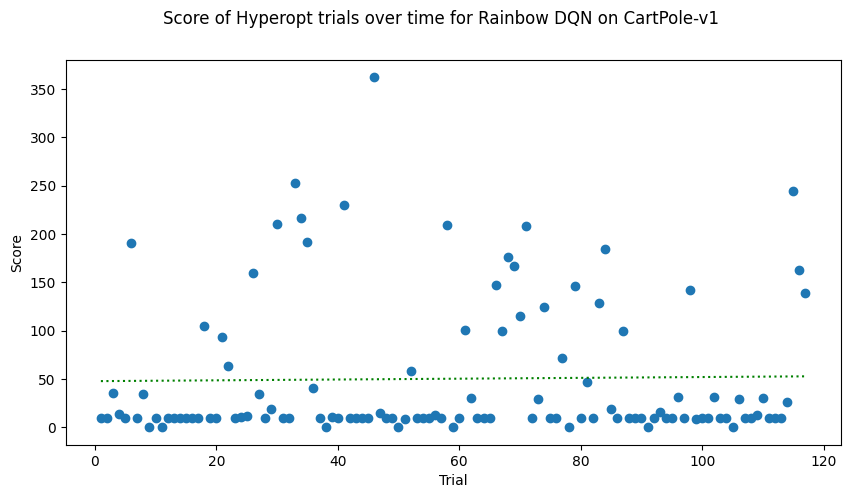

Failed trials: ~7%
Viable trials (based on final score): ~26%
Viable trials (throughout training): ~44%
Losses: [-362.2, -252.3, -244.8, -230.2, -216.4, -209.9, -209.7, -207.8, -192.0, -190.5, -184.5, -176.3, -167.1, -162.2, -159.8, -147.0, -146.1, -142.1, -139.1, -128.5, -124.4, -115.0, -104.9, -100.9, -99.5, -99.3, -93.8, -71.6, -63.1, -58.6, -46.5, -40.6, -35.9, -34.7, -33.9, -30.9, -30.8, -30.3, -29.8, -29.4, -29.1, -25.7, -19.0, -18.7, -15.3, -15.0, -13.2, -12.5, -12.3, -11.3, -10.7, -10.4, -9.9, -9.8, -9.8, -9.8, -9.8, -9.7, -9.7, -9.7, -9.7, -9.7, -9.7, -9.6, -9.6, -9.6, -9.6, -9.6, -9.5, -9.5, -9.5, -9.5, -9.5, -9.5, -9.5, -9.5, -9.4, -9.4, -9.4, -9.4, -9.4, -9.4, -9.4, -9.4, -9.4, -9.3, -9.3, -9.3, -9.3, -9.3, -9.3, -9.3, -9.3, -9.2, -9.2, -9.2, -9.2, -9.2, -9.2, -9.2, -9.2, -9.1, -9.1, -9.1, -9.1, -9.1, -9.1, -9.0, -8.9, 0, 0, 0, 0, 0, 0, 0, 0]
Scores: [362.2, 252.3, 244.8, 230.2, 216.4, 209.9, 209.7, 207.8, 192.0, 190.5, 184.5, 176.3, 167.1, 162.2, 159.8, 147.0, 146.1, 142.1

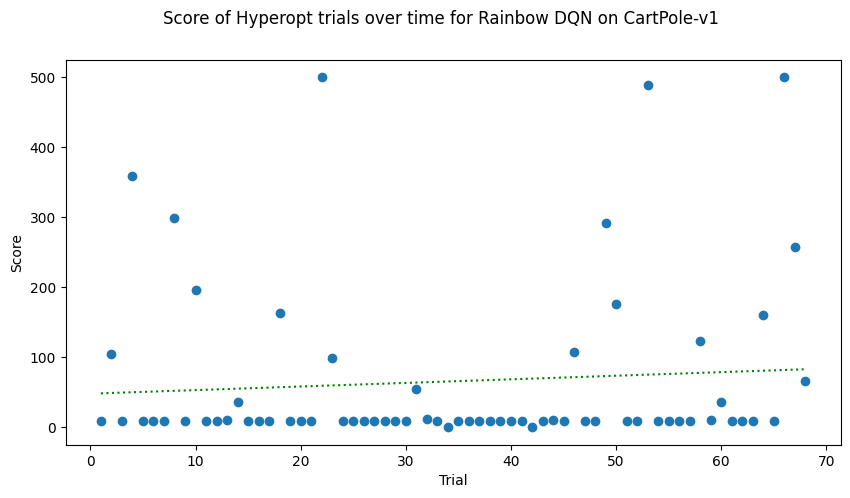

Failed trials: ~3%
Viable trials (based on final score): ~25%
Viable trials (throughout training): ~32%
Losses: [-500.0, -500.0, -489.3, -358.8, -299.2, -292.0, -257.8, -195.5, -176.6, -162.5, -160.4, -123.3, -107.7, -104.2, -99.3, -65.6, -54.1, -35.5, -35.5, -11.2, -10.9, -9.8, -9.7, -9.6, -9.6, -9.6, -9.6, -9.6, -9.6, -9.6, -9.6, -9.6, -9.6, -9.5, -9.5, -9.5, -9.5, -9.5, -9.4, -9.4, -9.4, -9.4, -9.4, -9.4, -9.4, -9.4, -9.4, -9.3, -9.3, -9.3, -9.3, -9.3, -9.3, -9.3, -9.3, -9.2, -9.2, -9.2, -9.2, -9.1, -9.1, -9.1, -9.1, -9.1, -9.0, -9.0, 0, 0]
Scores: [500.0, 500.0, 489.3, 358.8, 299.2, 292.0, 257.8, 195.5, 176.6, 162.5, 160.4, 123.3, 107.7, 104.2, 99.3, 65.6, 54.1, 35.5, 35.5, 11.2, 10.9, 9.8, 9.7, 9.6, 9.6, 9.6, 9.6, 9.6, 9.6, 9.6, 9.6, 9.6, 9.6, 9.5, 9.5, 9.5, 9.5, 9.5, 9.4, 9.4, 9.4, 9.4, 9.4, 9.4, 9.4, 9.4, 9.4, 9.3, 9.3, 9.3, 9.3, 9.3, 9.3, 9.3, 9.3, 9.2, 9.2, 9.2, 9.2, 9.1, 9.1, 9.1, 9.1, 9.1, 9.0, 9.0, 0, 0]
Final rolling averages: [157.5, 294.6, 421.6, 343.0, 123.4, 275.8, 282

/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:279: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axs = plt.subplots(


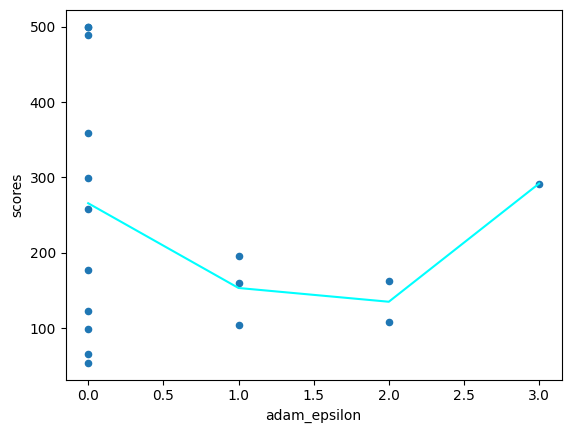

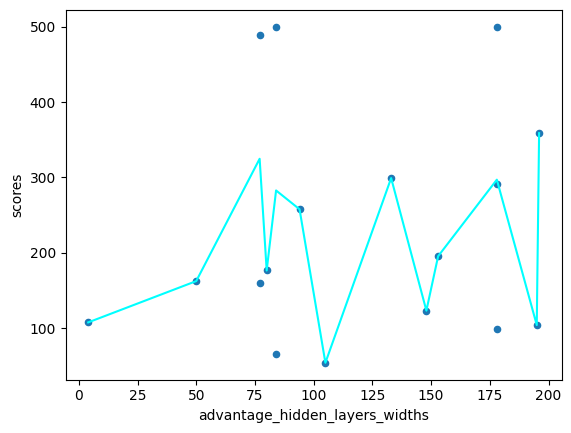

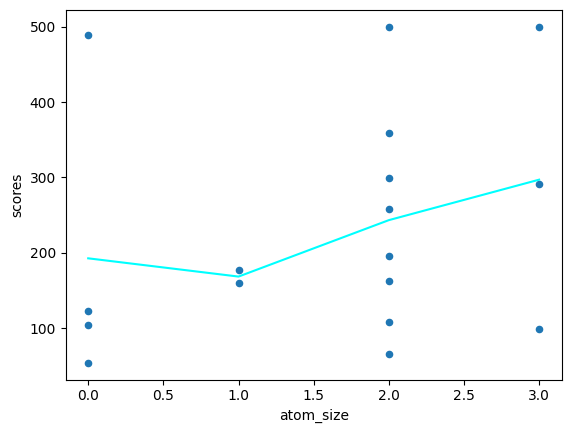

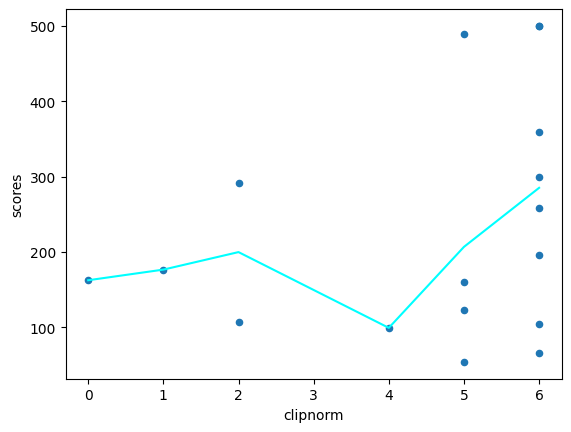

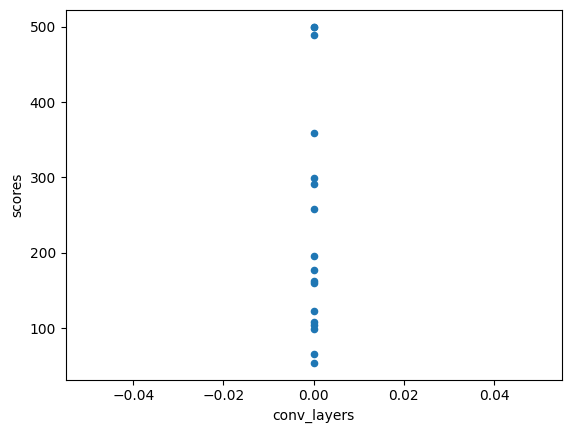

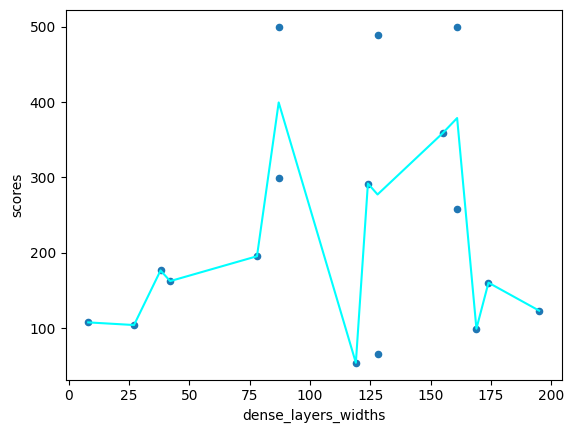

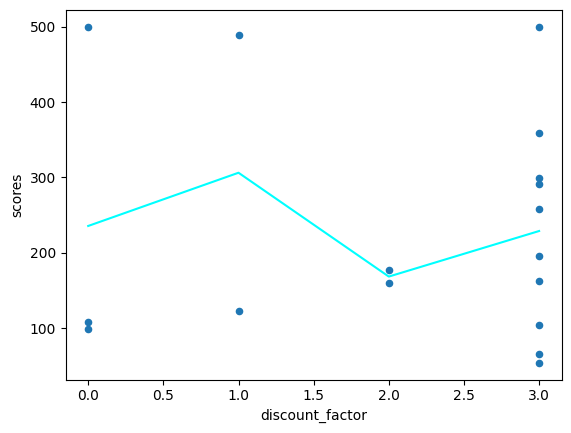

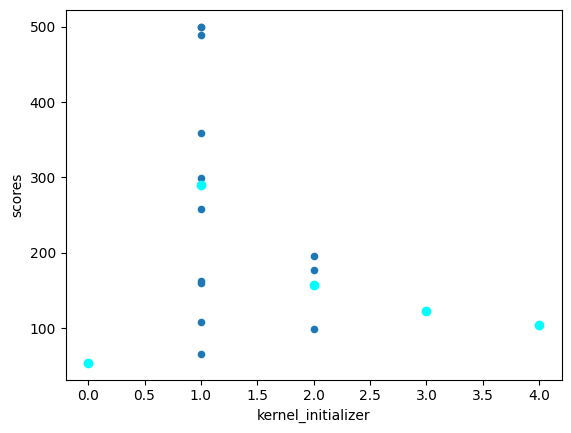

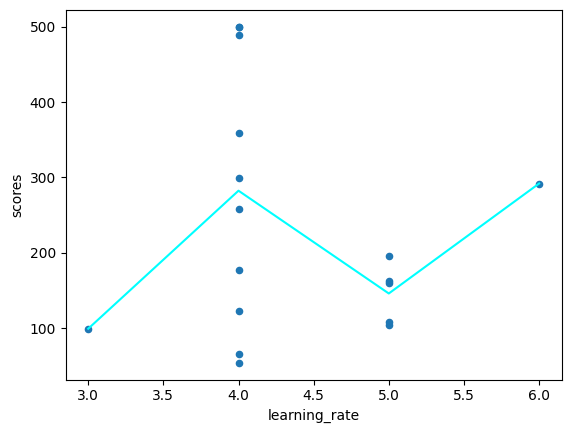

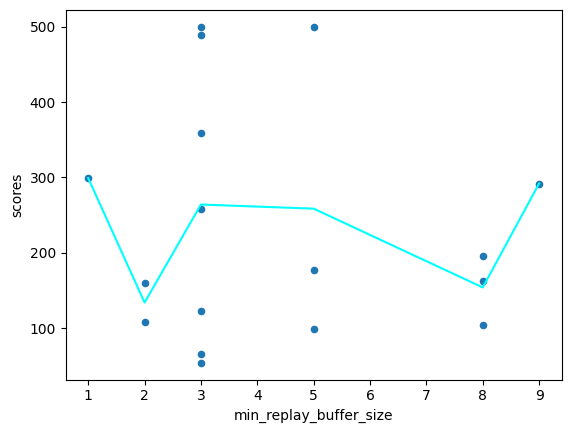

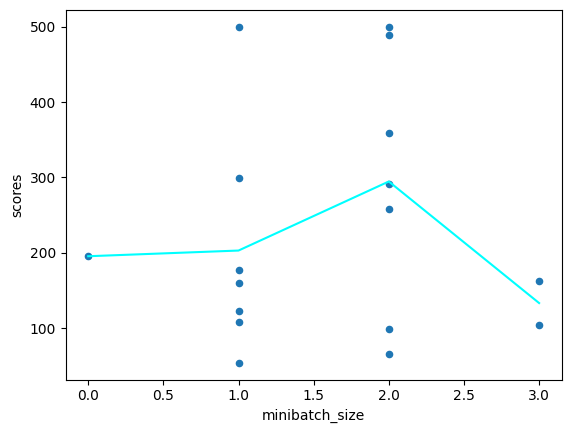

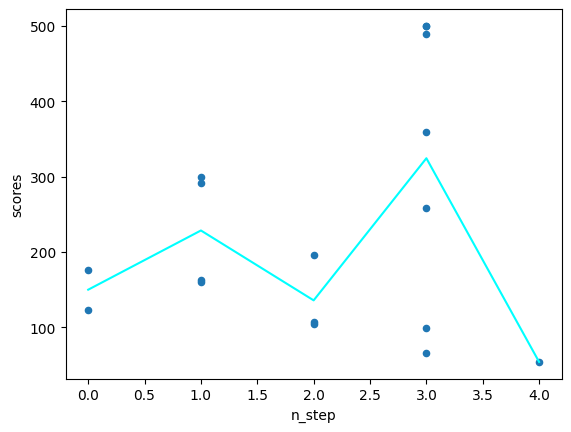

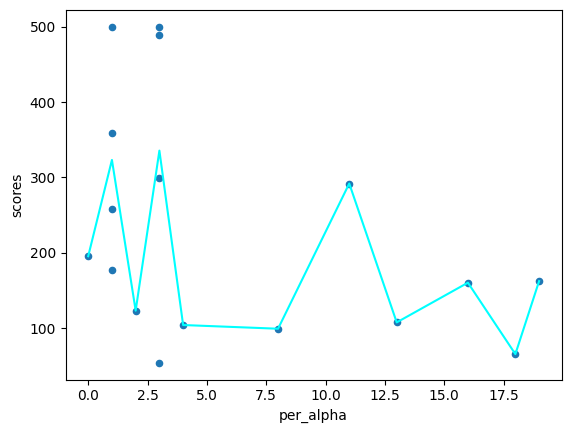

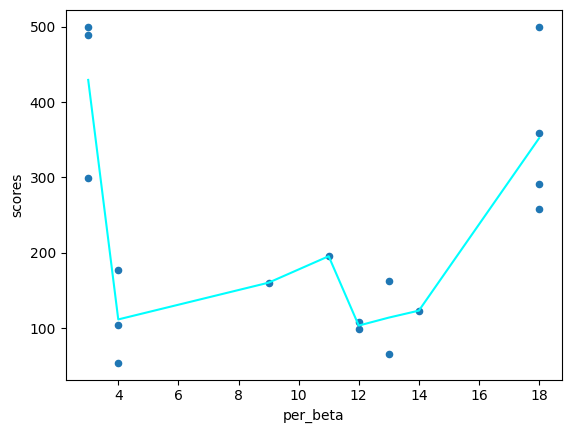

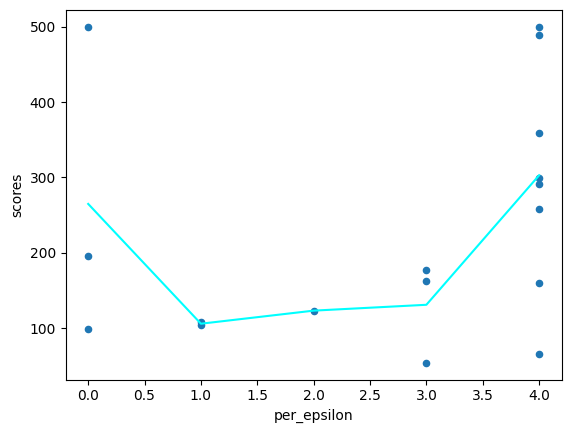

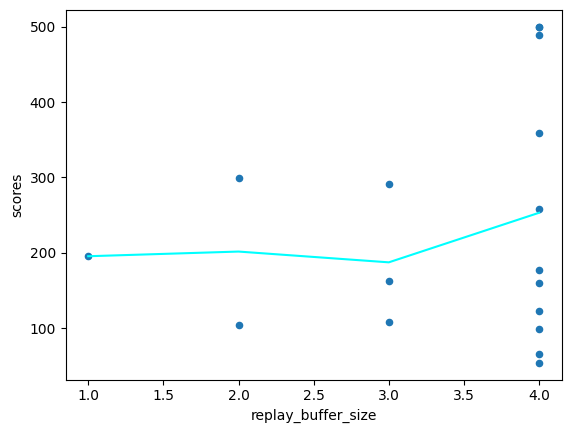

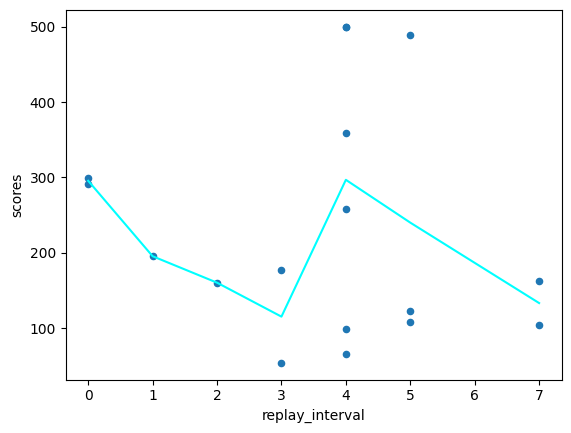

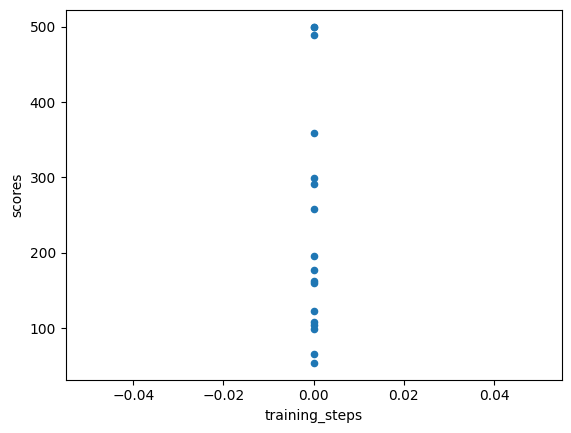

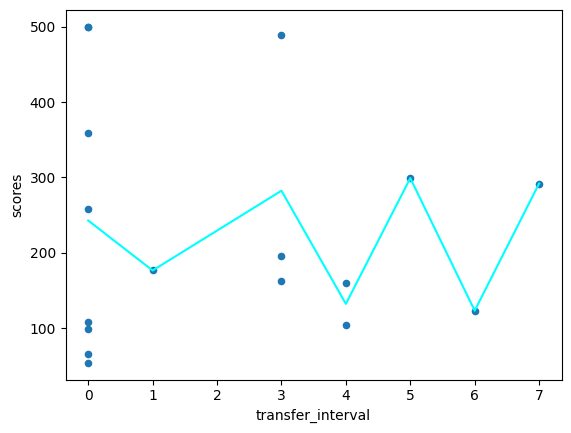

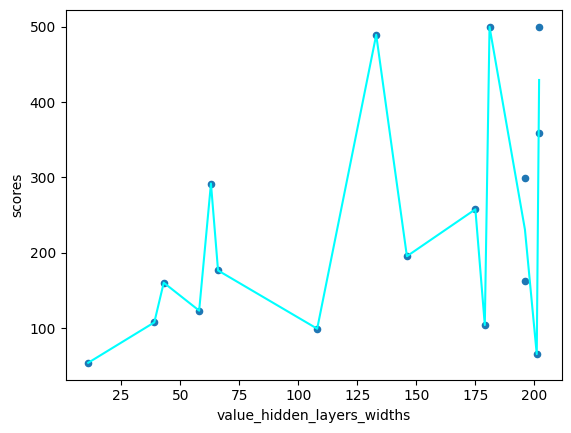

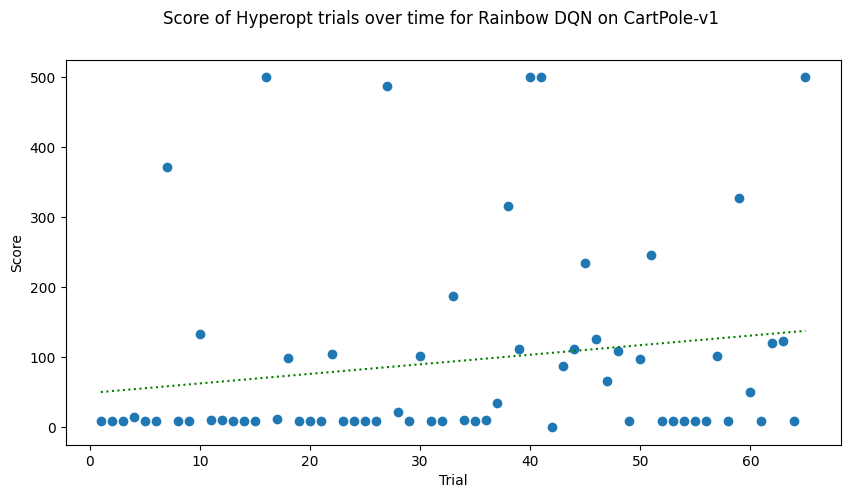

Failed trials: ~2%
Viable trials (based on final score): ~40%
Viable trials (throughout training): ~42%
Losses: [-500.0, -500.0, -500.0, -500.0, -487.8, -371.3, -327.1, -316.0, -246.4, -234.2, -187.5, -132.7, -126.3, -123.5, -120.1, -112.0, -111.7, -108.4, -104.3, -101.7, -101.5, -98.5, -96.9, -86.8, -65.4, -50.4, -35.3, -22.4, -14.2, -11.5, -10.2, -9.9, -9.8, -9.7, -9.6, -9.6, -9.5, -9.5, -9.4, -9.4, -9.4, -9.4, -9.4, -9.3, -9.3, -9.3, -9.3, -9.3, -9.3, -9.3, -9.2, -9.2, -9.2, -9.2, -9.2, -9.2, -9.2, -9.0, -9.0, -8.9, -8.9, -8.9, -8.9, -8.7, 0]
Scores: [500.0, 500.0, 500.0, 500.0, 487.8, 371.3, 327.1, 316.0, 246.4, 234.2, 187.5, 132.7, 126.3, 123.5, 120.1, 112.0, 111.7, 108.4, 104.3, 101.7, 101.5, 98.5, 96.9, 86.8, 65.4, 50.4, 35.3, 22.4, 14.2, 11.5, 10.2, 9.9, 9.8, 9.7, 9.6, 9.6, 9.5, 9.5, 9.4, 9.4, 9.4, 9.4, 9.4, 9.3, 9.3, 9.3, 9.3, 9.3, 9.3, 9.3, 9.2, 9.2, 9.2, 9.2, 9.2, 9.2, 9.2, 9.0, 9.0, 8.9, 8.9, 8.9, 8.9, 8.7, 0]
Final rolling averages: [371.8, 459.4, 322.6, 411.7, 495.2, 361.

/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:279: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axs = plt.subplots(


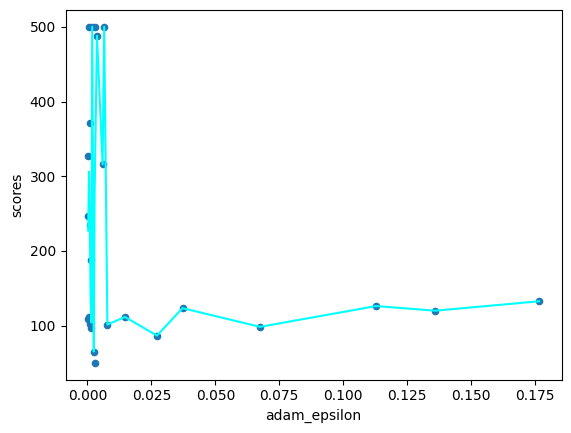

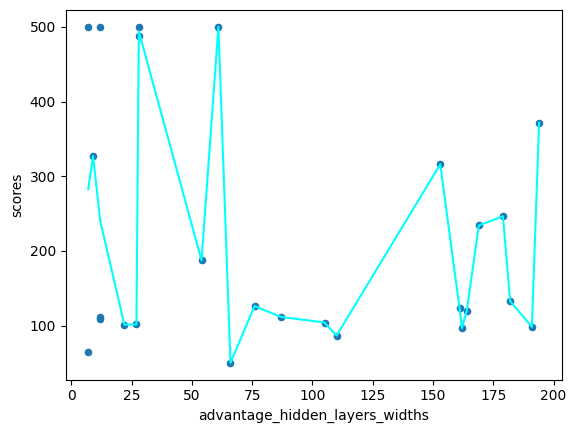

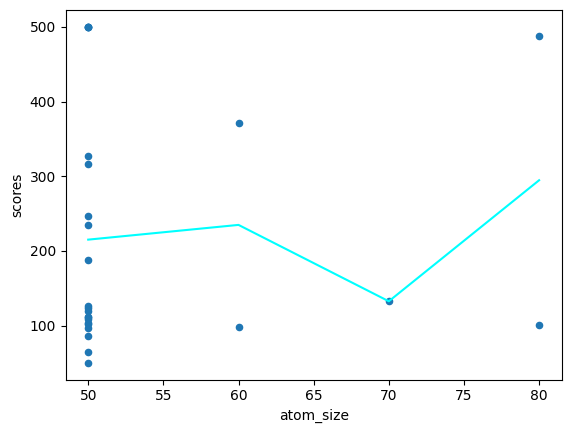

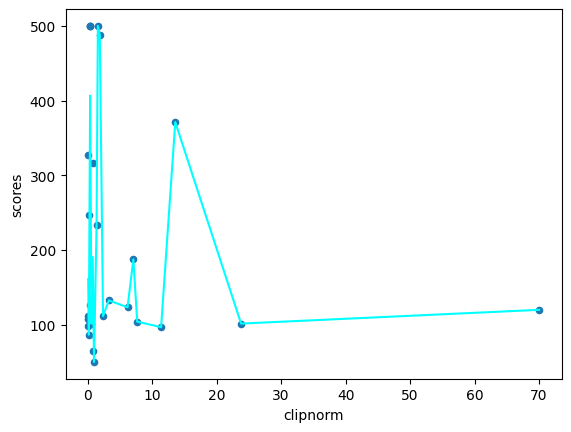

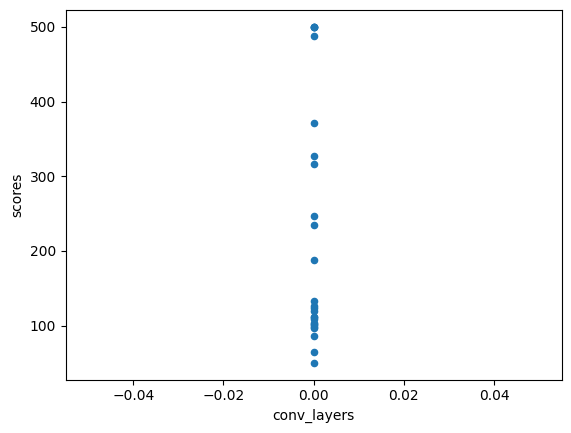

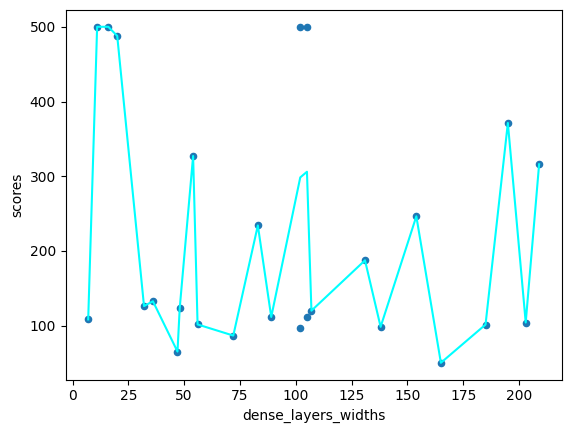

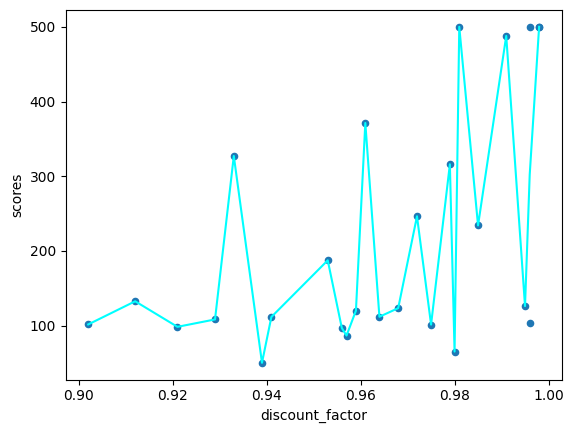

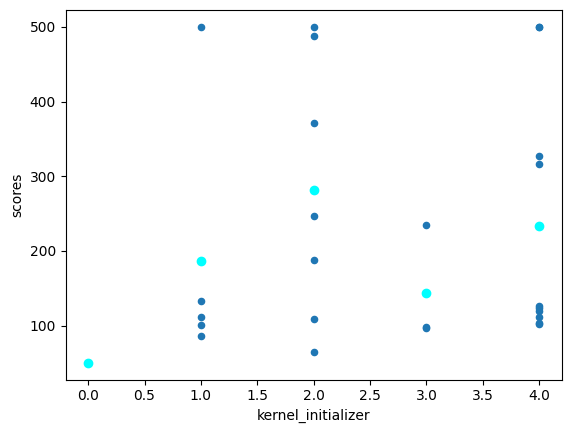

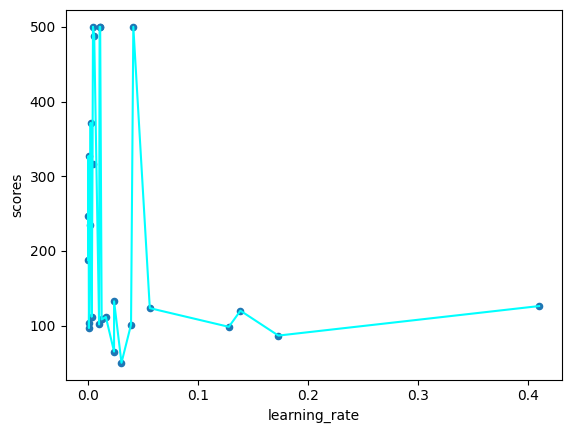

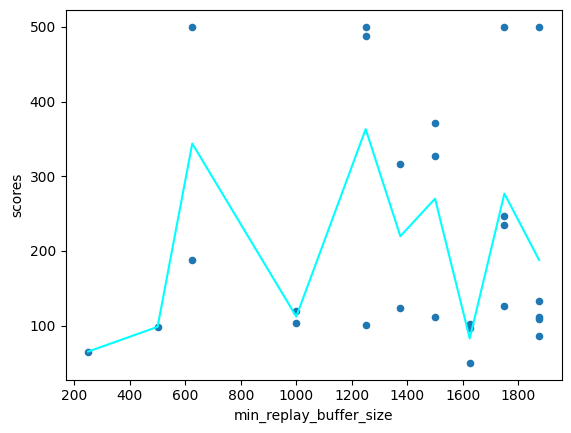

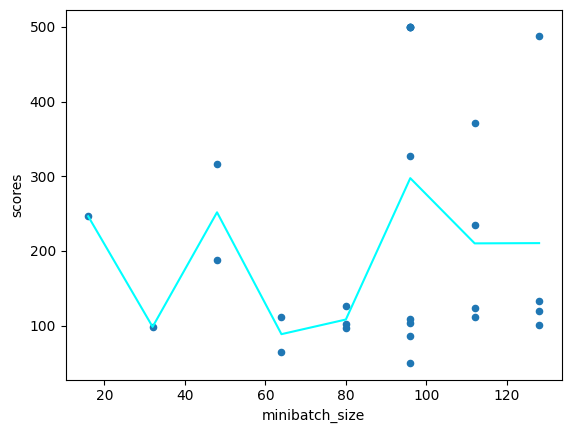

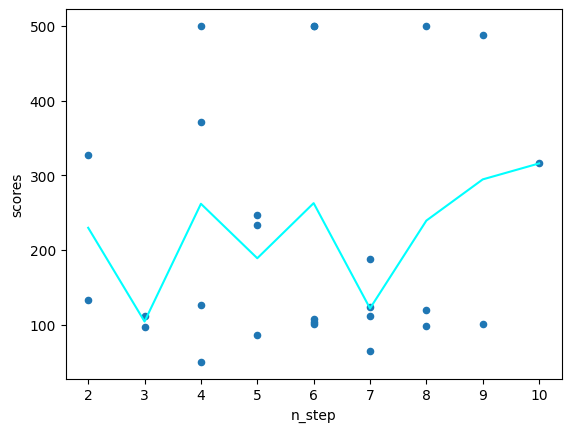

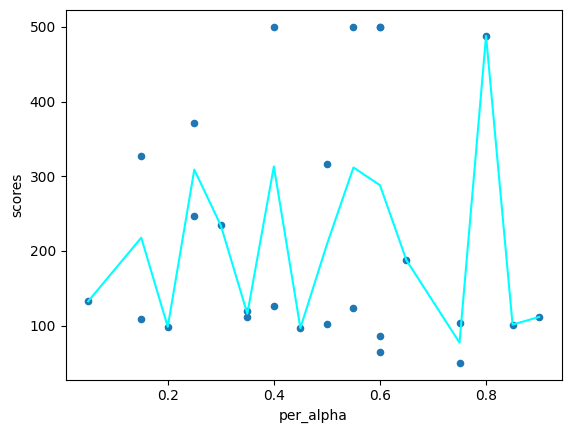

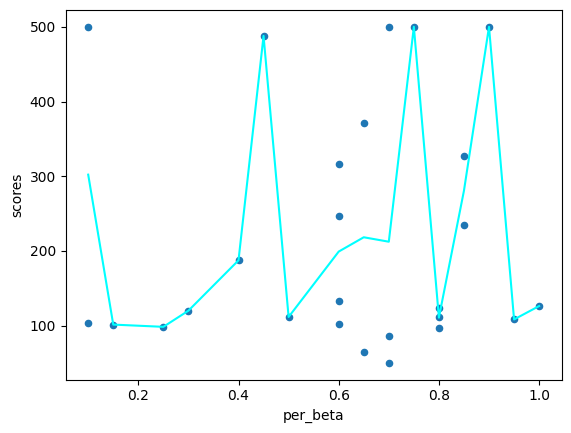

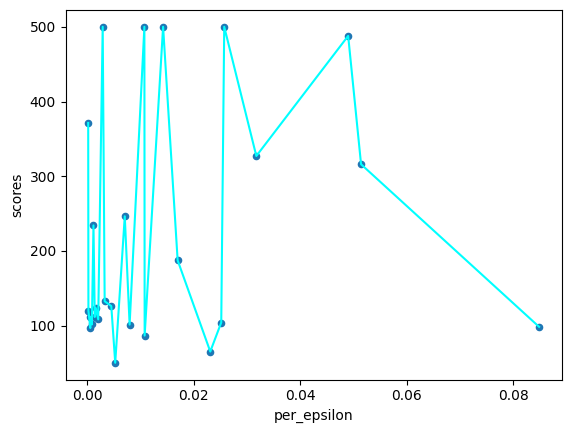

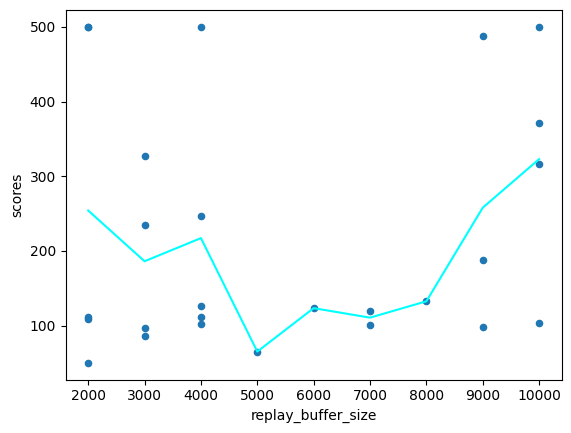

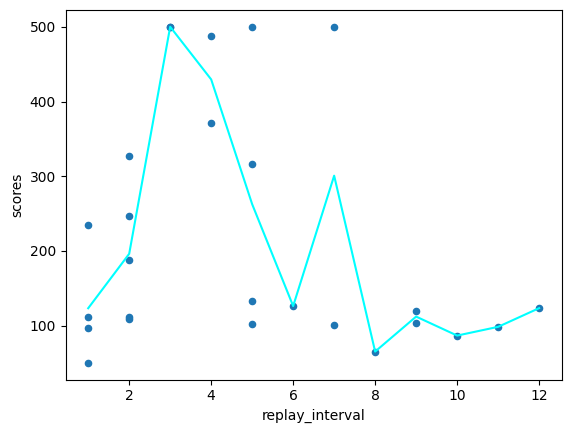

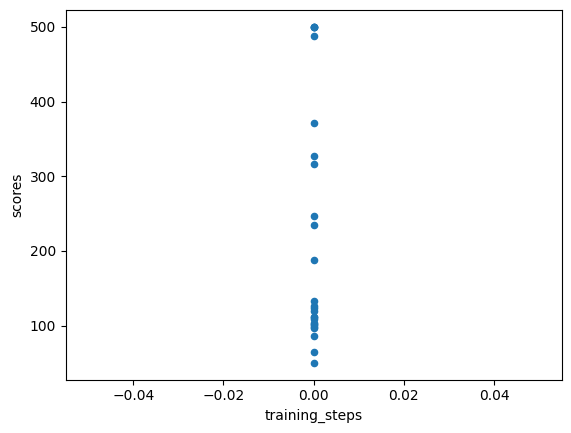

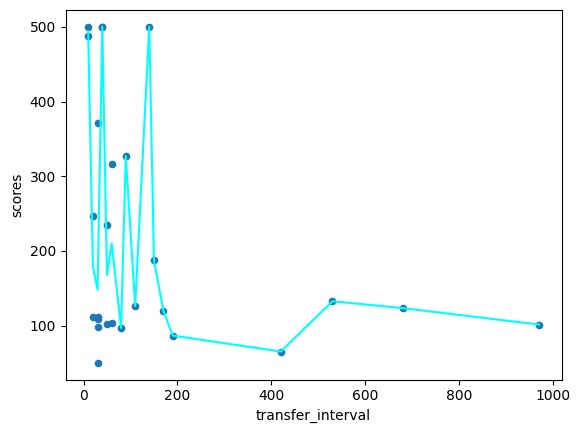

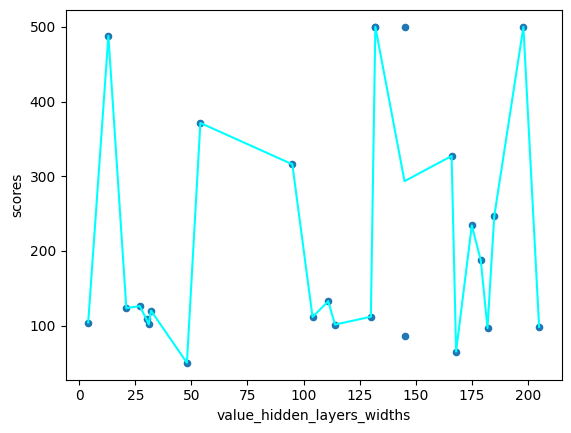

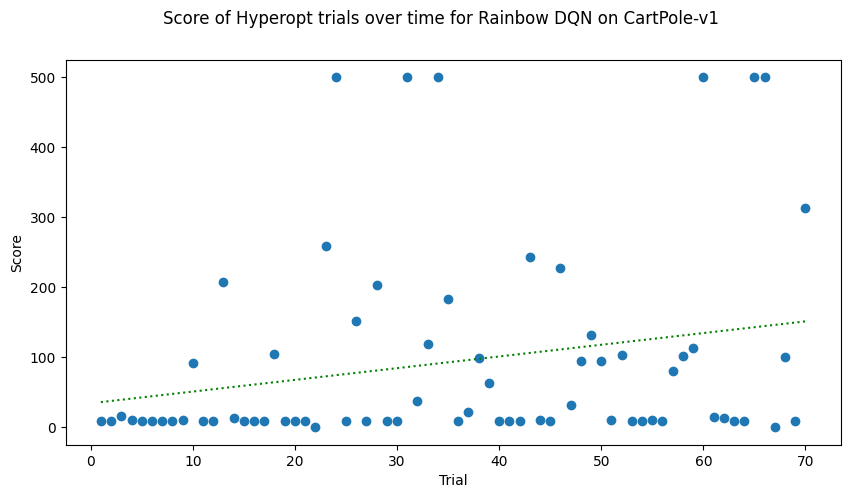

Failed trials: ~3%
Viable trials (based on final score): ~39%
Viable trials (throughout training): ~51%
Losses: [-443.6, -440.0, -358.9, -322.2, -311.2, -303.0, -299.6, -297.8, -294.2, -277.7, -252.4, -243.6, -227.0, -216.0, -214.0, -213.5, -207.3, -202.2, -168.2, -164.5, -149.8, -133.2, -125.6, -120.5, -111.4, -107.1, -89.9, -78.2, -60.3, -29.8, -26.8, -25.1, -15.8, -15.5, -13.4, -11.9, -11.5, -11.4, -11.1, -10.6, -10.5, -9.8, -9.8, -9.6, -9.6, -9.5, -9.5, -9.5, -9.5, -9.5, -9.5, -9.5, -9.4, -9.4, -9.4, -9.4, -9.4, -9.4, -9.4, -9.4, -9.3, -9.3, -9.3, -9.3, -9.2, -9.2, -9.1, -9.1, 0, 0]
Scores: [312.6, 500.0, 151.6, 500.0, 500.0, 31.6, 95.0, 203.2, 227.0, 258.6, 207.6, 500.0, 243.6, 94.4, 102.8, 500.0, 101.6, 15.0, 500.0, 62.8, 183.0, 119.4, 104.8, 98.2, 100.2, 132.0, 91.8, 112.6, 81.0, 38.0, 12.6, 21.6, 13.4, 9.6, 9.0, 9.6, 8.8, 15.8, 10.6, 9.0, 9.6, 8.6, 8.8, 9.4, 9.0, 9.8, 9.2, 9.2, 9.0, 9.0, 9.6, 9.4, 9.2, 9.8, 9.2, 9.0, 9.8, 9.6, 9.4, 8.8, 9.2, 9.6, 9.8, 9.4, 9.0, 9.6, 9.0, 9.2, 0

/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/packages/utils/utils/utils.py:279: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axs = plt.subplots(


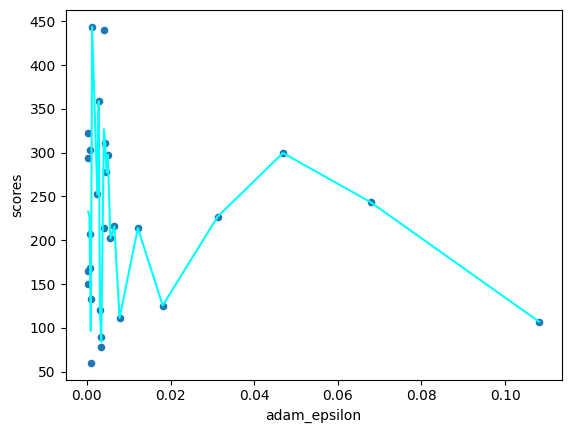

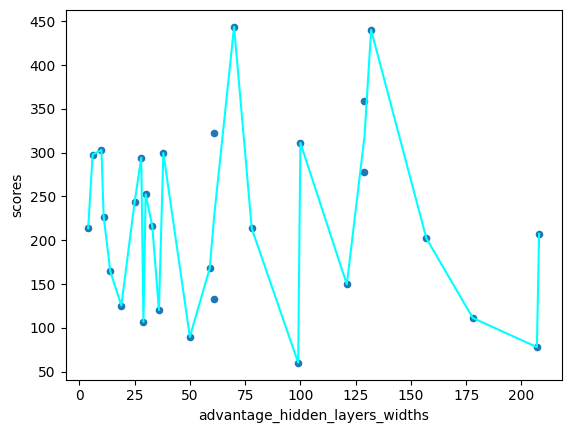

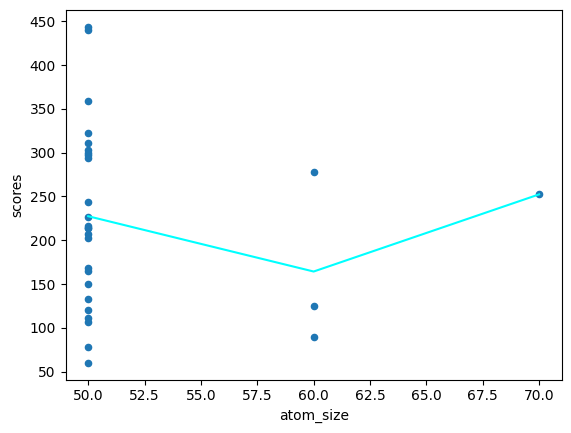

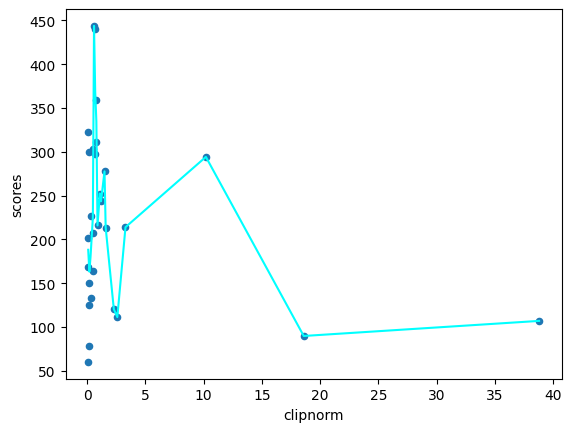

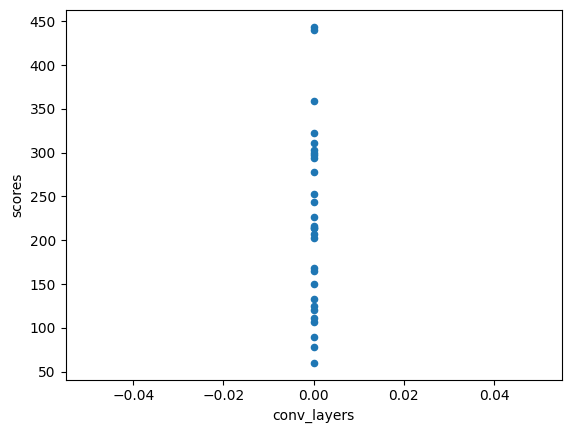

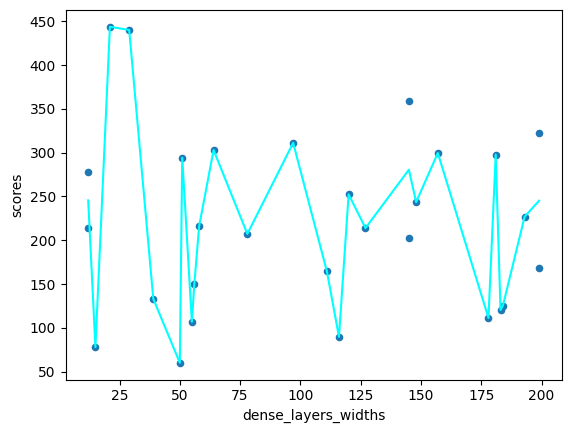

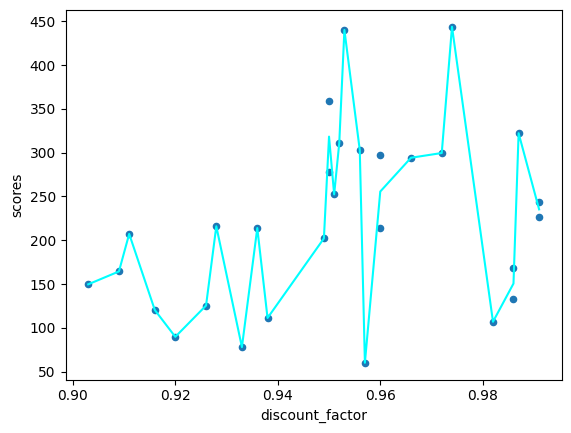

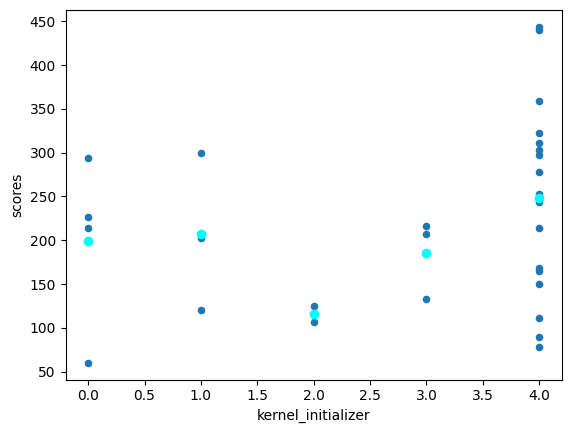

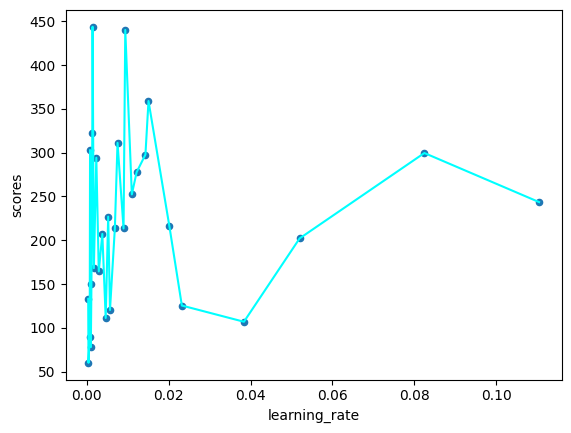

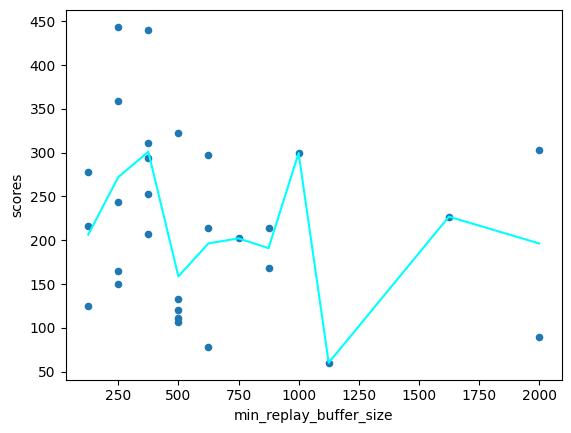

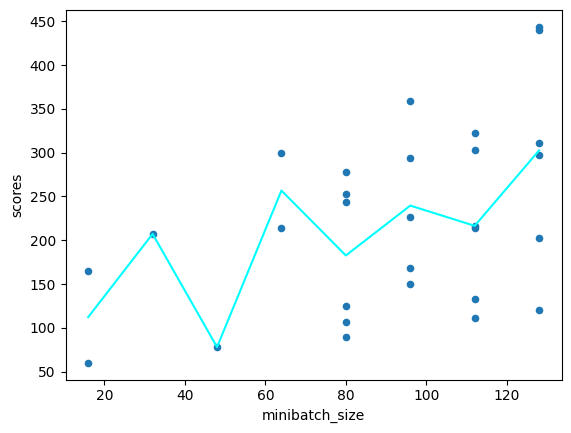

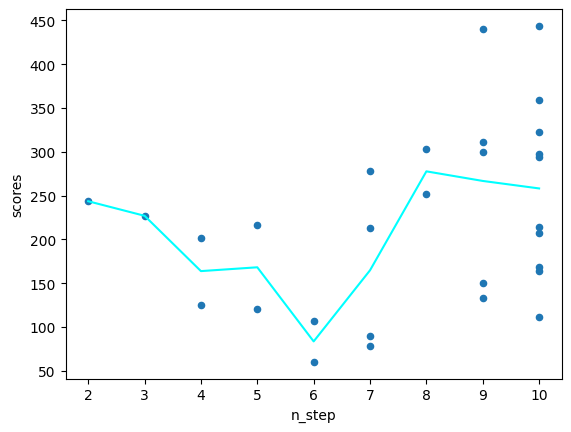

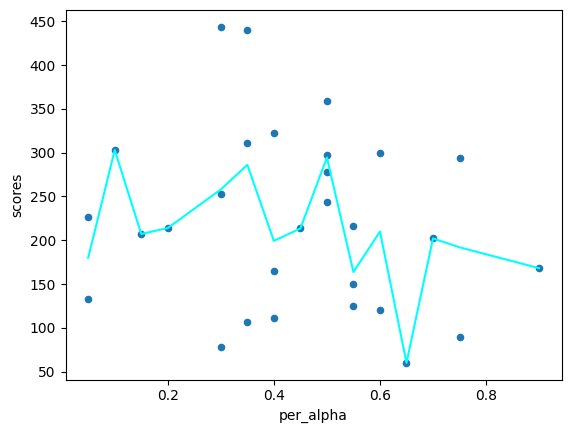

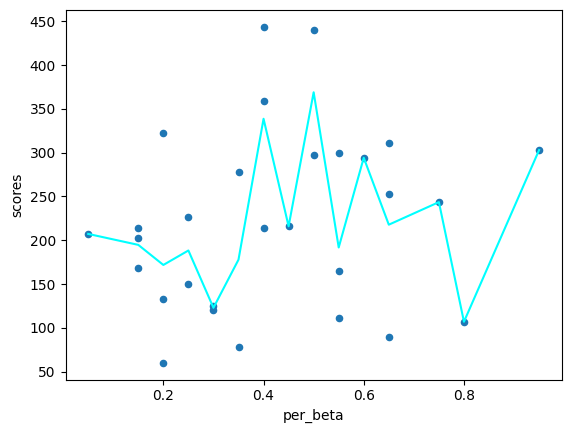

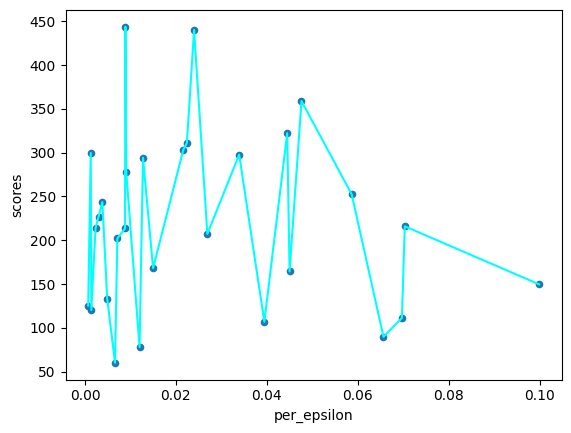

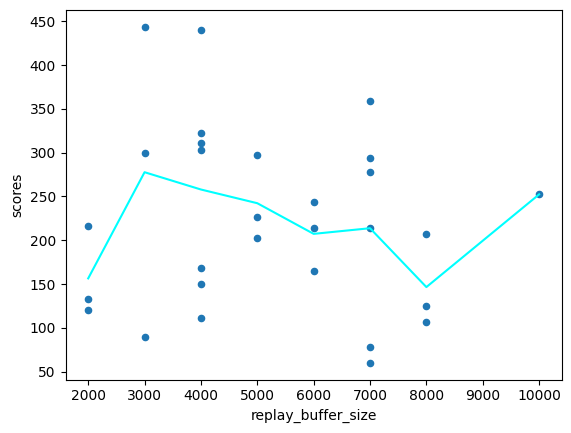

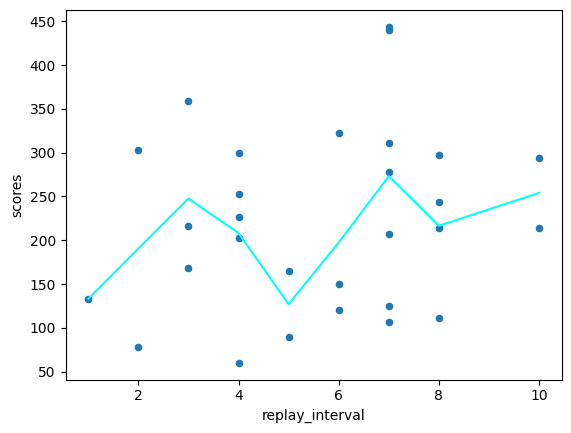

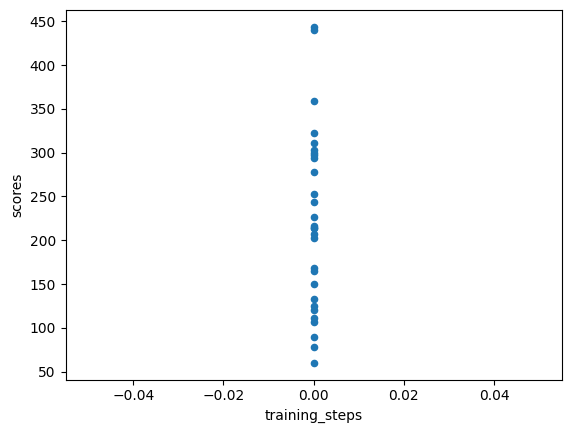

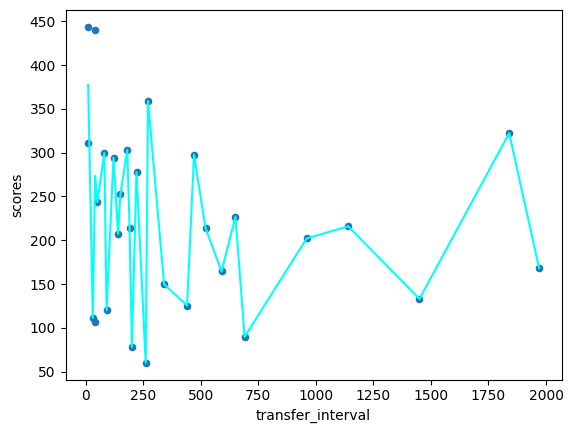

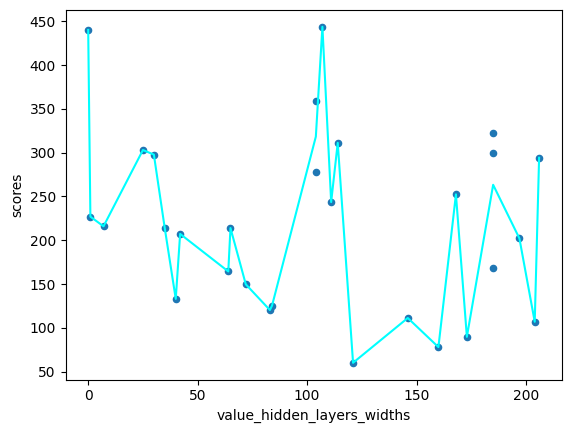

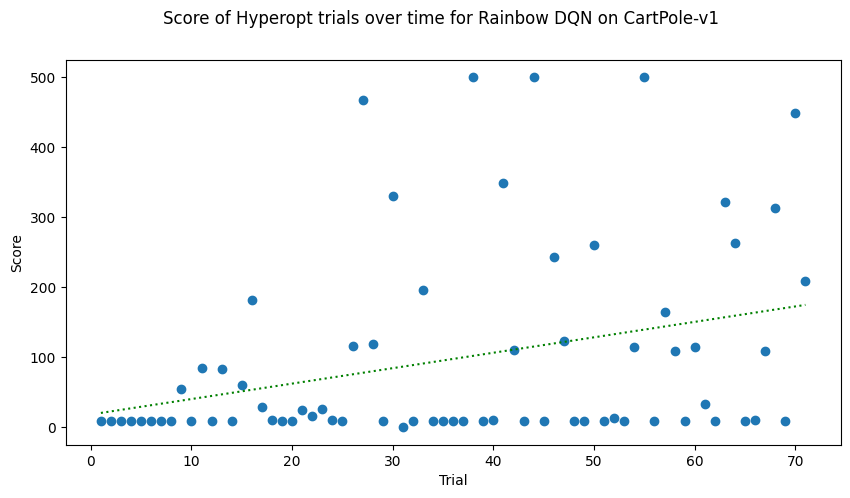

Failed trials: ~1%
Viable trials (based on final score): ~39%
Viable trials (throughout training): ~52%
Losses: [-493.5, -423.79999999999995, -405.9, -389.6, -389.0, -378.0, -342.1, -267.9, -257.5, -251.3, -238.6, -225.0, -224.45, -222.65, -201.6, -155.45, -154.8, -113.95, -113.65, -113.0, -111.0, -109.95, -109.55000000000001, -104.35, -91.0, -89.5, -84.19999999999999, -70.14999999999999, -66.2, -40.85, -28.65, -25.200000000000003, -24.75, -12.399999999999999, -12.100000000000001, -11.2, -11.1, -11.0, -10.9, -10.85, -10.2, -10.149999999999999, -9.9, -9.6, -9.55, -9.55, -9.5, -9.5, -9.5, -9.45, -9.45, -9.4, -9.4, -9.4, -9.350000000000001, -9.350000000000001, -9.35, -9.35, -9.35, -9.35, -9.3, -9.3, -9.3, -9.3, -9.25, -9.25, -9.25, -9.2, -9.100000000000001, -9.05, 0]
Scores: [500.0, 448.8, 467.0, 500.0, 500.0, 321.6, 349.0, 312.8, 182.4, 243.6, 208.8, 263.8, 330.8, 195.4, 260.0, 165.0, 114.0, 122.6, 110.8, 55.0, 109.6, 116.6, 118.8, 114.2, 84.0, 109.4, 26.4, 32.6, 83.4, 60.6, 29.0, 16.6, 

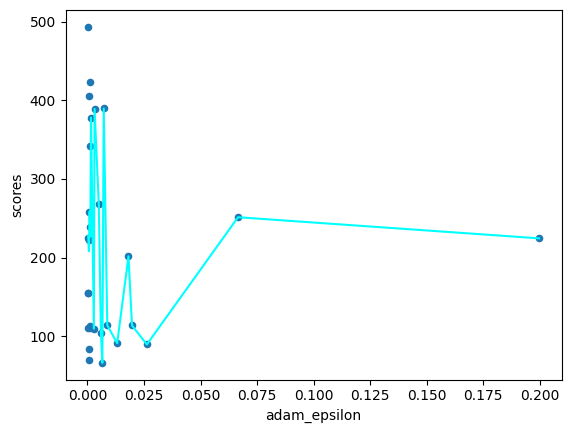

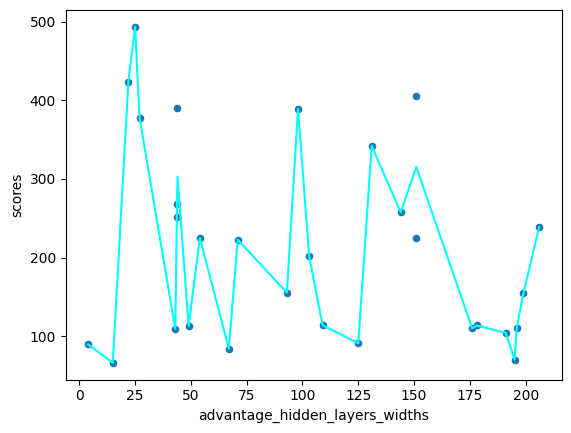

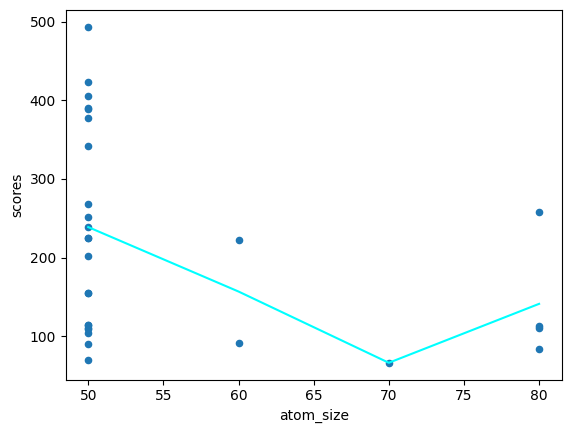

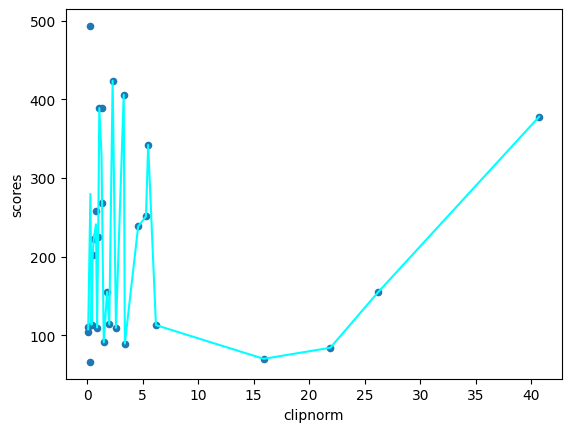

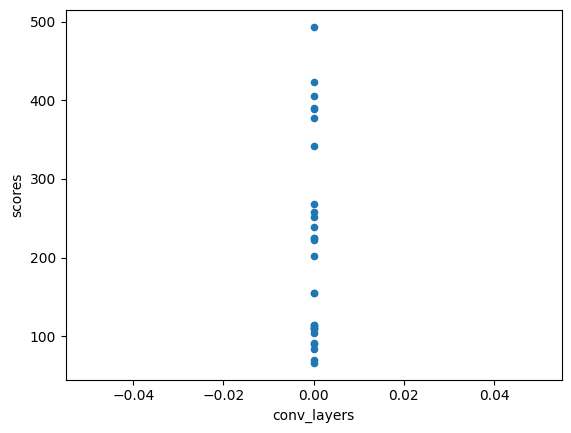

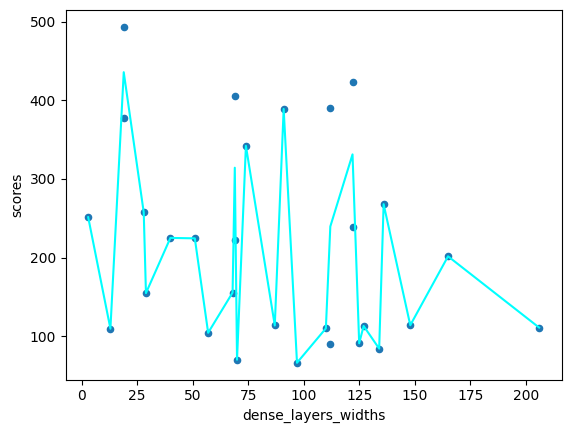

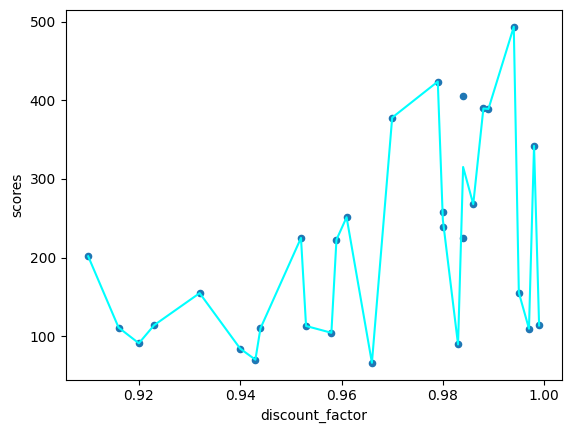

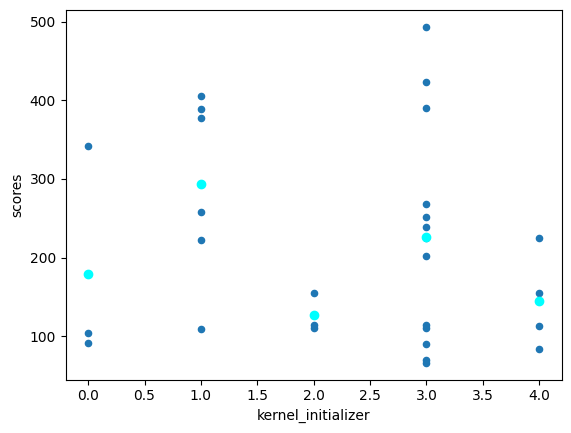

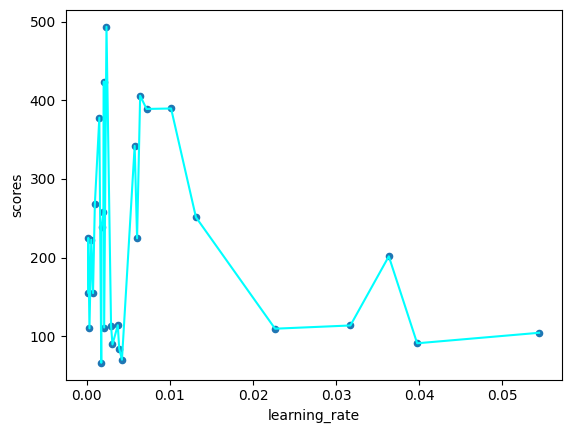

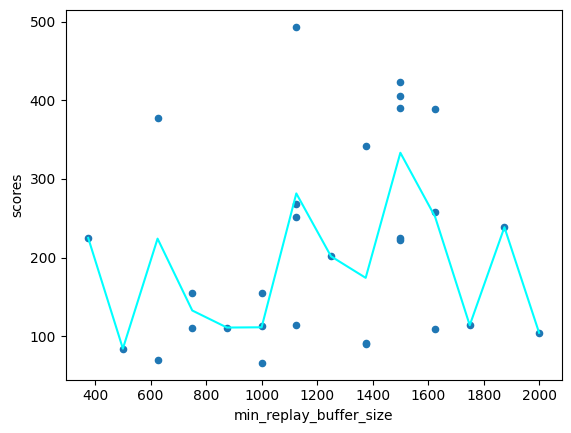

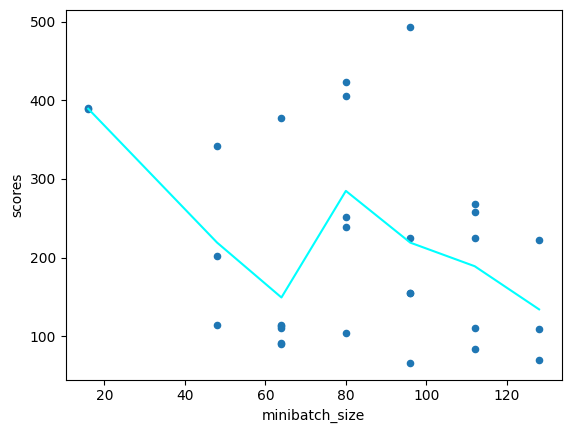

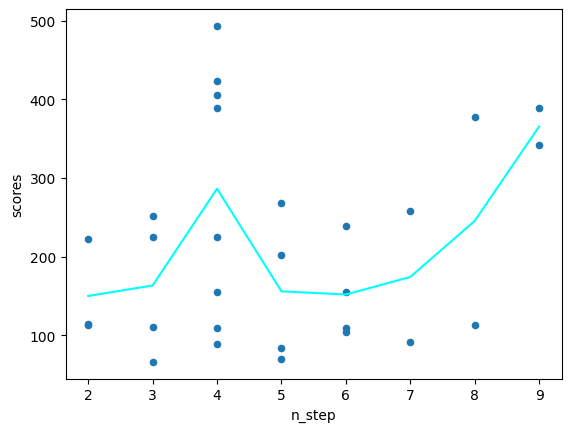

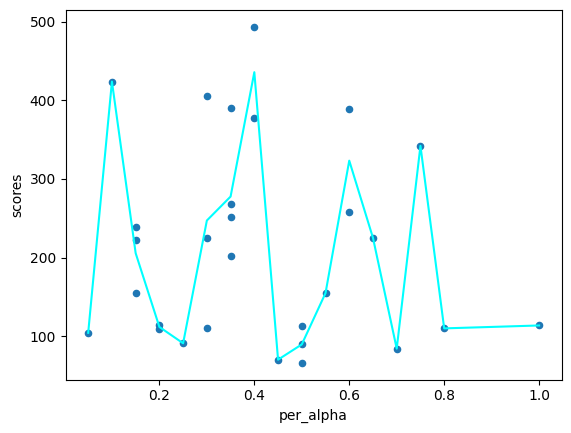

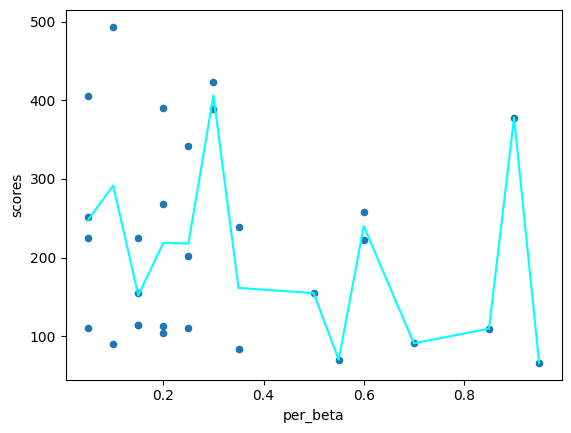

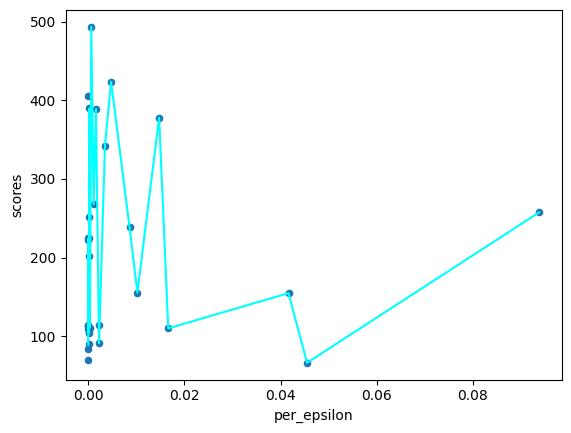

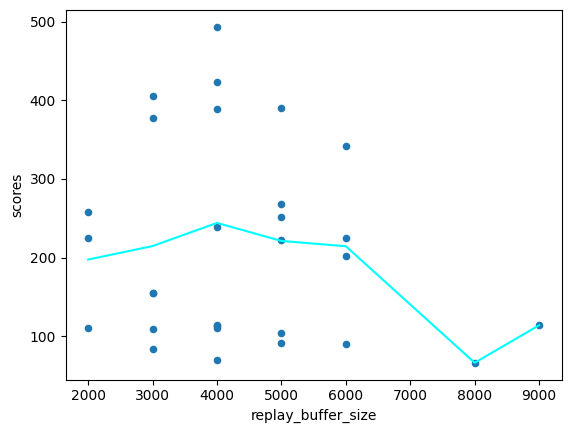

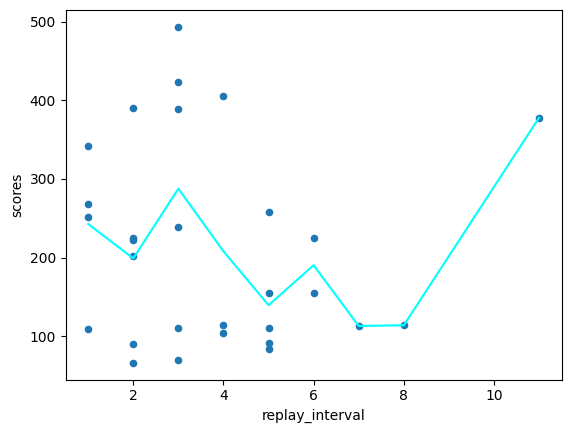

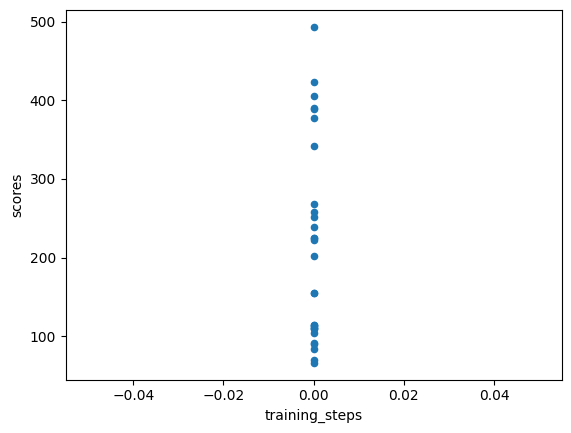

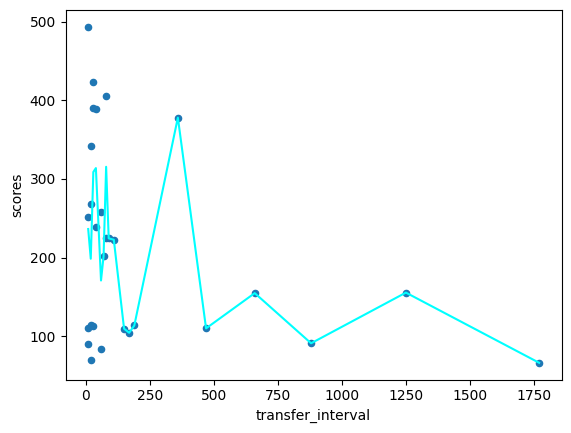

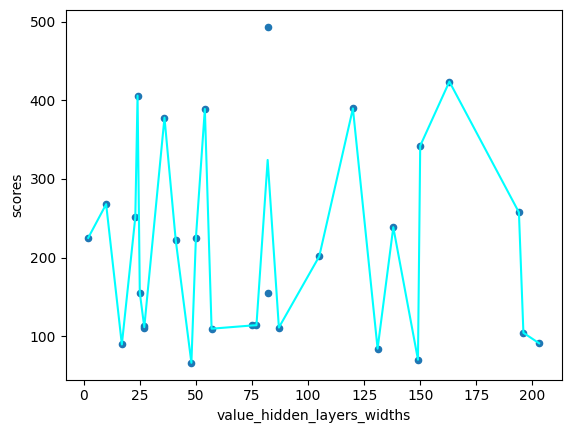

In [1]:
from utils import hyperopt_analysis, graph_hyperparameter_importance
%matplotlib inline

viable_trial_threshold = 50
final_trial = 0

data_dir = "./tensorflow_choice_trials"
hyperopt_analysis(data_dir, 'CartPole-v1_trials', viable_trial_threshold, 4999, final_trial)
# trials_file = 'CartPole-v1_trials.p'
# search_space_file = 'tensorflow_choice_search_search_space.pkl'
# graph_hyperparameter_importance(data_dir, trials_file, search_space_file, viable_trial_threshold)

data_dir = "./torch_choice_trials"
hyperopt_analysis(data_dir, 'CartPole-v1_trials', viable_trial_threshold, 9999, final_trial)
trials_file = 'CartPole-v1_trials.p'
search_space_file = 'torch_choice_search_search_space.pkl'
graph_hyperparameter_importance(data_dir, trials_file, search_space_file, viable_trial_threshold)

data_dir = "./quantized_search_trials"
hyperopt_analysis(data_dir, 'CartPole-v1_quantized_search_trials', viable_trial_threshold, 9999, final_trial)
trials_file = 'CartPole-v1_quantized_search_trials.p'
search_space_file = 'torch_quantized_search_search_space.pkl'
graph_hyperparameter_importance(data_dir, trials_file, search_space_file, viable_trial_threshold)

data_dir = "./rolling_average_eval_trials"
hyperopt_analysis(data_dir, 'CartPole-v1_rolling_average_eval_trials', viable_trial_threshold, 9999, final_trial, "rolling_average")
trials_file = 'CartPole-v1_rolling_average_eval_trials.p'
search_space_file = 'rolling_average_eval_search_space.pkl'
graph_hyperparameter_importance(data_dir, trials_file, search_space_file, viable_trial_threshold)

data_dir = "./final_score_rolling_average_eval_trials"
hyperopt_analysis(data_dir, 'CartPole-v1_final_score_rolling_average_eval_trials', viable_trial_threshold, 9999, final_trial, "final_score_rolling_average")
trials_file = 'CartPole-v1_final_score_rolling_average_eval_trials.p'
search_space_file = 'final_score_rolling_average_eval_search_space.pkl'
graph_hyperparameter_importance(data_dir, trials_file, search_space_file, viable_trial_threshold)


In [ ]:
# Speed of results
# Hyperparameter similarity of consecutive trials as a measure of confidence
# Search space size vs convergence speed
# Compare results to tuning only one system at a time

Rainbow results on Classic Control environments
Training steps: 
Evaluation: 
Hyperparamaters: 

Rainbow results on (subset of) Atari games
Training steps: 
Evaluation: 
Hyperparamaters: 